In [180]:
#| default_exp models.conv

In [181]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Convolution-based Model

In [219]:
#| export
import torch.nn as nn
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from lightning import LightningModule, Trainer
from lightning.pytorch.tuner.tuning import Tuner
from lightning.pytorch.callbacks import LearningRateFinder
from lightning.pytorch.loggers import CSVLogger

from torch_lr_finder import LRFinder
from torchmetrics import Accuracy
from hydra.utils import instantiate
from omegaconf import OmegaConf

from matplotlib import pyplot as plt
import pandas as pd

from nimrod.image.datasets import MNISTDataModule
from nimrod.utils import get_device
from nimrod.models.core import Classifier, find_optimal_lr

import logging
logger = logging.getLogger(__name__)

## Conv Layer

Using a convolution with a stride of 2 instead of max pooling essentially achieves the same goal of downsampling an image by reducing its spatial dimensions, but with the key difference that the convolution layer can learn more complex feature combinations from overlapping regions, while max pooling only selects the maximum value within a window, potentially losing information about the finer details within that region; making the convolution with stride approach often preferred for preserving more spatial information in a neural network. 

In [183]:
#| export
class ConvLayer(nn.Module):
    def __init__(self,
                in_channels:int=3, # input channels
                out_channels:int=16, # output channels
                kernel_size:int=3, # kernel size
                activation:bool=True
                ):

        super().__init__()
        self.activation = activation
        # use stride 2 for downsampling instead of max or average pooling with stride 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 2, kernel_size//2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        if self.activation:
            x = self.relu(x)
        return x

### Usage

In [184]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
c = ConvLayer(1, 16, 3, True)
# flatten all dims except batch
Y = torch.flatten(c(X), 1)
print(Y.shape)

torch.Size([64, 3136])


## Convnet Model
Simple convolution network for image recognition

In [203]:
#| export
class ConvNet(nn.Module):
    def __init__(
            self,
            in_channels:int=1, # input channels
            out_channels:int=10 # num_classes
            ):
        super().__init__()
        self.net = nn.Sequential(
            ConvLayer(in_channels, 8, kernel_size=5), #14x14
            nn.BatchNorm2d(8),
            ConvLayer(8, 16), #7x7
            nn.BatchNorm2d(16),
            ConvLayer(16, 32), #4x4
            nn.BatchNorm2d(32),
            ConvLayer(32, 64), #2x2
            nn.BatchNorm2d(64),
            ConvLayer(64, 10, activation=False), #1x1
            nn.BatchNorm2d(10),
            nn.Flatten()

        )

    def forward(self, x:torch.Tensor # input image tensor of dimension (B, C, W, H)
                ) -> torch.Tensor: # output probs (B, N_classes)

        return self.net(x)

### Usage

#### Mock data

In [204]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape

torch.Size([64, 1, 28, 28])

#### Model

In [205]:
# model instantiation
convnet = ConvNet()
out = convnet(X)
print(out.shape)

# from config
cfg = OmegaConf.load('../config/image/model/conv.yaml')
print(cfg.nnet)
convnet = instantiate(cfg.nnet)
print(convnet(X).shape)

torch.Size([64, 10])
{'_target_': 'nimrod.models.conv.ConvNet', 'in_channels': 1, 'out_channels': '${num_classes}'}
torch.Size([64, 10])


### Training

#### Dataloaders

In [132]:
# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')

datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.batch_size = 2048
datamodule.setup()

# one data point 
X,y = datamodule.data_test[0]
print("X (C,H,W): ", X.shape, "y: ", y)

# a batch of data via dataloader
XX,YY = next(iter(datamodule.test_dataloader()))
print("XX (B,C,H,W): ", XX.shape, "YY: ", YY.shape)

print(len(datamodule.data_train))
print(len(datamodule.data_train)//cfg.datamodule.batch_size)

[17:44:38]


X (C,H,W):  torch.Size([1, 28, 28]) y:  7
XX (B,C,H,W):  torch.Size([64, 1, 28, 28]) YY:  torch.Size([64])
56000
875


#### Model & hardware

In [133]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
model = ConvNet()
model = model.to(device)

mps


#### Loss, optimizer, scheduler

##### LR finder

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-02


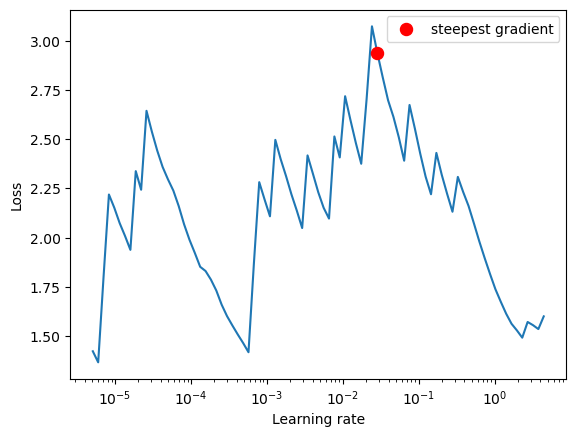

Suggested lr: 0.028480358684358012


In [107]:
#| notest

criterion = nn.CrossEntropyLoss()
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    
# Initialize LR Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
    
# Run LR range test
lr_finder.range_test(
    datamodule.train_dataloader(),
    start_lr=1e-6,      # Extremely small starting learning rate
    end_lr=10,          # Large ending learning rate
    num_iter=100,   # Number of iterations to test
    smooth_f=0.05,   # Smoothing factor for the loss
    diverge_th=5, 
)
    
# Plot the learning rate vs loss
_, lr_found = lr_finder.plot(log_lr=True)
print('Suggested lr:', lr_found)
    
lr_finder.reset()
    

    

##### 1-cycle training loop

In [174]:
#| notest

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.setup()

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
model = ConvNet()
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
steps_per_epoch = len(datamodule.data_train) // cfg.datamodule.batch_size
total_steps = steps_per_epoch* N_EPOCHS
print(len(datamodule.data_train), cfg.datamodule.batch_size, steps_per_epoch, total_steps)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epochs, epochs=1)
N_EPOCHS = 10
scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr_found,  # Peak learning rate
        # total_steps=len(datamodule.data_train) * N_EPOCHS,  # Total training iterations
        steps_per_epoch=steps_per_epoch,
        epochs=N_EPOCHS,
        pct_start=0.3,  # 30% of training increasing LR, 70% decreasing
        anneal_strategy='cos',  # Cosine annealing
        div_factor=10,  # Initial lr = max_lr / div_factor
        # final_div_factor=1e4,
        three_phase=False  # Two phase LR schedule (increase then decrease)
    )

%time
losses = []
lrs = []
current_step = 0

for epoch in range(N_EPOCHS):
    i = 0
    model.train()
    for images, labels in datamodule.train_dataloader():
        if current_step >= total_steps:
            print(f"Reached total steps: {current_step}/{total_steps}")
            break
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        scheduler.step()    
        current_step += 1
    
        losses.append(loss.item())
        # current_lr = scheduler.get_last_lr()[0]
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        if not (i % 100):
            print(f"Loss {loss.item():.4f}, Current LR: {current_lr:.10f}, Step: {current_step}/{total_steps}")
        i += 1
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in datamodule.test_dataloader():
            # model expects input (B,H*W)
            images = images.to(device)
            labels = labels.to(device)
            # Pass the input through the model
            outputs = model(images)
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum()

        # Print the accuracy
    print(f"Epoch {epoch + 1}: Loss {loss.item():.4f}, Accuracy = {100 * correct / total:.2f}%")
    # print(f'Current LR: {optimizer.param_groups[0]["lr"]:.5f}')



[18:41:29]
[18:41:29]
[18:41:29]
[18:41:29]
[18:41:29]


mps
56000 2048 27 270
CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.1 μs
Loss 2.6601, Current LR: 0.0028579167, Step: 1/270
Epoch 1: Loss 0.4741, Accuracy = 93.50%
Loss 0.4183, Current LR: 0.0102985865, Step: 29/270
Epoch 2: Loss 0.1712, Accuracy = 97.70%
Loss 0.1686, Current LR: 0.0235986053, Step: 57/270
Epoch 3: Loss 0.0812, Accuracy = 98.00%
Loss 0.0807, Current LR: 0.0284312060, Step: 85/270
Epoch 4: Loss 0.0666, Accuracy = 98.31%
Loss 0.0597, Current LR: 0.0263912154, Step: 113/270
Epoch 5: Loss 0.0533, Accuracy = 98.64%
Loss 0.0401, Current LR: 0.0217663079, Step: 141/270
Epoch 6: Loss 0.0436, Accuracy = 98.71%
Loss 0.0311, Current LR: 0.0155403618, Step: 169/270
Epoch 7: Loss 0.0239, Accuracy = 98.69%
Loss 0.0295, Current LR: 0.0090378521, Step: 197/270
Epoch 8: Loss 0.0271, Accuracy = 98.80%
Loss 0.0175, Current LR: 0.0036420882, Step: 225/270
Epoch 9: Loss 0.0187, Accuracy = 98.89%
Loss 0.0232, Current LR: 0.0005009367, Step: 253/270
Reached total steps: 270/270
E

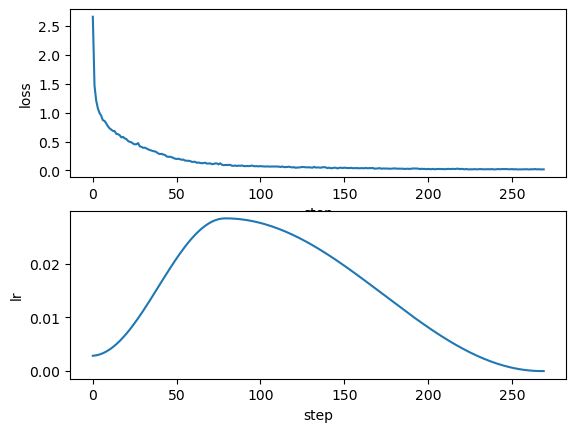

In [176]:
#| notest
plt.figure(1)
plt.subplot(211)
plt.ylabel('loss')
plt.xlabel('step')
plt.plot(losses)
plt.subplot(212)
plt.ylabel('lr')
plt.xlabel('step')
plt.plot(lrs)

## ConvNetX

In [260]:
#| export

class ConvNetX(Classifier, LightningModule):
    def __init__(
            self,
            nnet:ConvNet,
            num_classes:int,
            optimizer:torch.optim.Optimizer,
            scheduler:torch.optim.lr_scheduler,
            ):
        logger.info("ConvNetX: init")
        super().__init__(num_classes, optimizer, scheduler)
        self.save_hyperparameters(logger=False, ignore=['nnet'])
        self.lr = optimizer.keywords['lr'] # for lr finder
        self.nnet = nnet

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnet(x)
    
    def _step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        preds = y_hat.argmax(dim=1)
        return loss, preds, y
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.forward(x)
        return y_hat.argmax(dim=1)

### Usage

In [207]:
cfg = OmegaConf.load('../config/image/model/conv.yaml')
model = instantiate(cfg)

[21:53:39]
[21:53:39]


In [208]:
B, C, H, W = 64, 1, 28, 28
X = torch.rand(B, C, H, W)
X.shape
print(model(X).shape)

torch.Size([64, 10])


### Nimrod training

In [261]:
# model
cfg = OmegaConf.load('../config/image/model/conv.yaml')
model = instantiate(cfg)

# data module config
cfg = OmegaConf.load('../config/image/data/mnist.yaml')
cfg.datamodule.batch_size = 2048
cfg.datamodule.num_workers = 0
datamodule = instantiate(cfg.datamodule)
# datamodule.prepare_data()
datamodule.setup()

[22:27:51]
[22:27:51]
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
[22:27:51]
[22:27:51]
[22:27:51]
[22:27:51]
[22:27:51]


In [262]:
trainer = Trainer(
    accelerator="auto",
    max_epochs=3,
    logger=CSVLogger("logs", name="mnist_convnet")
    )


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [263]:
#| notest
trainer.fit(model, datamodule.train_dataloader(), datamodule.val_dataloader())



  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | loss         | CrossEntropyLoss   | 0      | train
1 | train_acc    | MulticlassAccuracy | 0      | train
2 | val_acc      | MulticlassAccuracy | 0      | train
3 | test_acc     | MulticlassAccuracy | 0      | train
4 | train_loss   | MeanMetric         | 0      | train
5 | val_loss     | MeanMetric         | 0      | train
6 | test_loss    | MeanMetric         | 0      | train
7 | val_acc_best | MaxMetric          | 0      | train
8 | nnet         | ConvNet            | 30.5 K | train
------------------------------------------------------------
30.5 K    Trainable params
0         Non-trainable params
30.5 K    Total params
0.122     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


tensor(2.3023, device='mps:0')
tensor(2.3024, device='mps:0')


/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/slegroux/miniforge3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

tensor(2.8205, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(2.3376, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(2.0113, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.7268, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.5318, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.4073, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.2975, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.2293, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.1773, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.1211, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.0507, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(1.0264, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9816, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9353, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9536, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.9075, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.8970, device='mps:0', grad_fn=<NllLossBackward0

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(1.7100, device='mps:0')
tensor(1.7613, device='mps:0')
tensor(1.7142, device='mps:0')
tensor(1.7229, device='mps:0')
tensor(0.6929, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.7048, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6919, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6823, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6875, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6663, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6672, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6483, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6668, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6402, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6482, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6252, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6130, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6068, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.6011, device='mps:0', grad_fn=<NllLossBac

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.5687, device='mps:0')
tensor(0.5760, device='mps:0')
tensor(0.5642, device='mps:0')
tensor(0.5589, device='mps:0')
tensor(0.5277, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5384, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5272, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5212, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5327, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4961, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5047, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5021, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5024, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5002, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5009, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4895, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.5008, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4977, device='mps:0', grad_fn=<NllLossBackward0>)
tensor(0.4880, device='mps:0', grad_fn=<NllLossBac

Validation: |          | 0/? [00:00<?, ?it/s]

tensor(0.4381, device='mps:0')
tensor(0.4420, device='mps:0')
tensor(0.4373, device='mps:0')


`Trainer.fit` stopped: `max_epochs=3` reached.


tensor(0.4278, device='mps:0')


In [264]:
#| notest
csv_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(csv_path)
metrics.head(5)

,epoch,step,train/acc_epoch,train/acc_step,train/loss_epoch,train/loss_step,val/acc,val/acc_best,val/loss
0,0,27,NaN,NaN,NaN,NaN,0.409857,0.409857,1.727103
1,0,27,0.714696,NaN,1.147601,NaN,NaN,NaN,NaN
2,1,49,NaN,0.925781,NaN,0.574697,NaN,NaN,NaN
3,1,55,NaN,NaN,NaN,NaN,0.936857,0.936857,0.566965
4,1,55,0.917286,NaN,0.616894,NaN,NaN,NaN,NaN


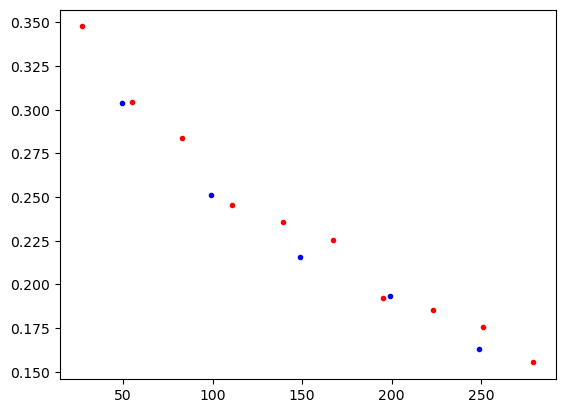

In [259]:
#| notest
plt.figure()
plt.plot(metrics['step'], metrics['train/loss_step'], 'b.-')
plt.plot(metrics['step'], metrics['val/loss'],'r.-')
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()